In [26]:
import os
import ase
import json
import ase.io
from ase import Atoms
import numpy as np
from pathlib import Path
from glob import glob
from tqdm import tqdm
from itertools import accumulate
from datetime import datetime
from omegaconf import DictConfig, OmegaConf

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from spec2struct.diffusion.diffusion_cfg import CSPDiffusion
from spec2struct.diffusion.property import CSPProperty
from spec2struct.utils.constants import cdvae_train_num_elements_distribution
from spec2struct.dataset.datamodule import CrystalDataModule, worker_init_fn
from spec2struct.dataset.dataset import CrystalDataset

### Instantiate the Forward Model
The forward model predicts node-level DOS from input structures

In [5]:
root_path = Path("outputs/dos_forward_model")
config_path = root_path / "hparams.yaml"
config = OmegaConf.load(config_path)

# get checkpoint
ckpt_path = glob(str(root_path / "*.ckpt"))[0]

# load model
forward_model = CSPProperty.load_from_checkpoint(ckpt_path, config=config)
forward_model.to('cuda')
print("Forward model loaded.")

Time independence: True
Forward model loaded.


### Instantiate the Data Module
We need to reuse some configs from the saved model folder

In [7]:
root_path = Path("outputs/dos_cfg")

config_path = root_path / 'hparams.yaml'
config = OmegaConf.load(config_path)
data_module = CrystalDataModule(config, scaler_path=str(root_path))
data_module.setup(stage="test")

/global/cfs/cdirs/m526/shuyi/m526playground/Spec2Struct/spec2struct/dataset/datamodule.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.lattice_scaler = torch.load(

Scaling property scaled_lattice with shape (30474, 6)
Scaling property y with shape (409493, 400)


### Create Adhoc Dataset and Dataloader
As an example, we will use the conditionally generated structures from running `generate_CFG_conditional.py`

In [8]:
# path to the folder containing .cif files
data_path = "structures/08032025_160513"

adhoc_dataset = CrystalDataset(
    name='adhoc',
    dataset_path=data_path,
    targets_path=None,
    save_path=data_path,
    prop=data_module.config.property,
    niggli=data_module.config.niggli,
    primitive=data_module.config.primitive,
    graph_method=data_module.config.graph_method,
    preprocess_workers=data_module.config.preprocess_workers,
    lattice_scale_method=data_module.config.lattice_scale_method,
    tolerance=data_module.config.tolerance,
)

adhoc_dataset.lattice_scaler = data_module.lattice_scaler
adhoc_dataset.scaler = data_module.scaler

adhoc_loader = DataLoader(
    adhoc_dataset,
    shuffle=False,
    batch_size=len(adhoc_dataset),
    num_workers=1,
    worker_init_fn=worker_init_fn,
)

Loading CIF files from directory structures/08032025_160513 ...


  0%|          | 0/5 [00:00<?, ?it/s]

### Get Ground Truth

In [11]:
# check the IDs of the reconstructed structures
batch = next(iter(adhoc_loader))
print(batch.structure_id)

['mp-19989', 'mp-22678', 'mp-1025231', 'mp-1102830', 'mp-1183466']


In [12]:
# since we reconstructed from test set
# we can find the ground truth structures and their DOS's from test.json
f = open("data/mp_dos/test.json")
raw_data = json.load(f)
f.close()

In [22]:
target_dos_dict = {x['structure_id']: np.array(x['y']) for x in raw_data if x['structure_id'] in batch.structure_id}

In [23]:
for k, v in target_dos_dict.items():
    print(k, v.shape)

mp-1025231 (7, 400)
mp-1102830 (12, 400)
mp-1183466 (4, 400)
mp-19989 (11, 400)
mp-22678 (6, 400)


### Get Predictions from Reconstructed Structures

In [28]:
forward_model.eval()

pred, _ = forward_model.infer(batch.to('cuda'))

# inverse transform
pred = data_module.scaler.inverse_transform(pred.to('cpu')).numpy()

split_indices = list(accumulate(batch.num_atoms.cpu().numpy()))[:-1]
reconstructed_dos_dict = dict(zip(batch.structure_id, np.split(pred, split_indices)))

In [29]:
for k, v in reconstructed_dos_dict.items():
    print(k, v.shape)

mp-19989 (11, 400)
mp-22678 (6, 400)
mp-1025231 (7, 400)
mp-1102830 (12, 400)
mp-1183466 (4, 400)


### Plot

In [30]:
import matplotlib.pyplot as plt

In [40]:
def plot_single(key, predicted, target):
    n_atoms, y_dim = predicted.shape
    n_cols = n_atoms
    n_rows = 1

    aspect_ratio_per_subplot = 1.0  # Aspect ratio (width/height) per subplot, can be adjusted
    subplot_width = 2  # Width of each subplot, can be adjusted
    subplot_height = subplot_width / aspect_ratio_per_subplot

    fig_width = n_cols * subplot_width
    fig_height = n_rows * subplot_height

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    axes = axs.flatten()

    for i in range(n_cols):
        ax = axes[i]
        ax.plot(target[i], label='target', color='darkorange', linewidth=1.5, alpha=0.75)
        ax.plot(predicted[i], label='generated', color='royalblue', linewidth=1.5, alpha=0.75)

    fig.suptitle(f"{key}")

    lines, labels = axs[0].get_legend_handles_labels()
    fig.legend(lines, ['Target', 'Generated'], loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

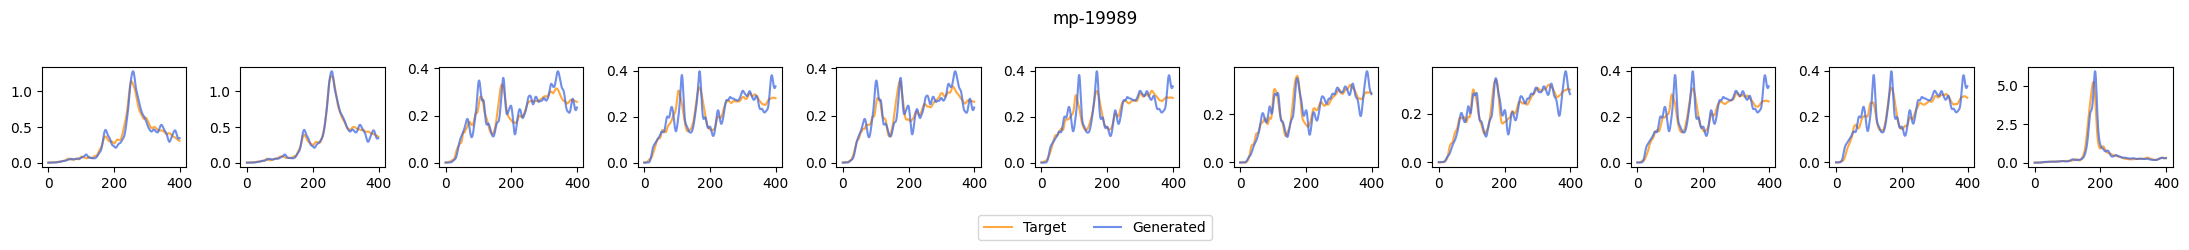

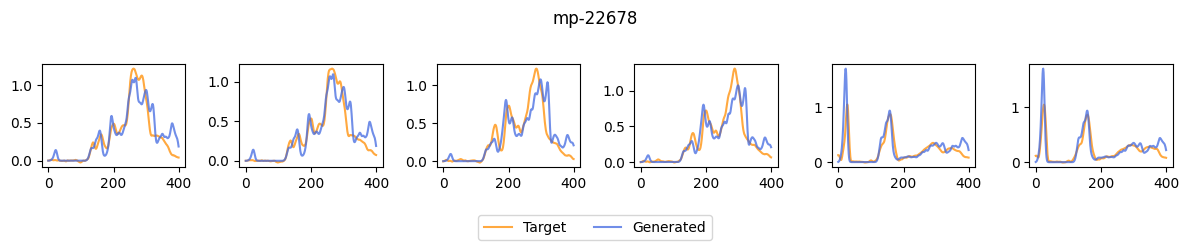

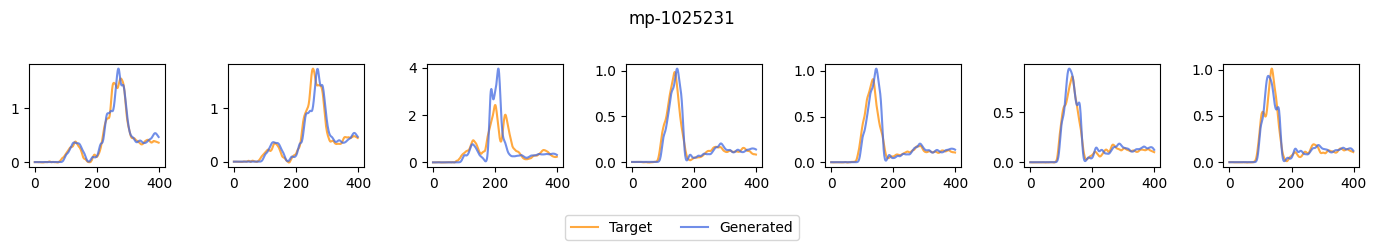

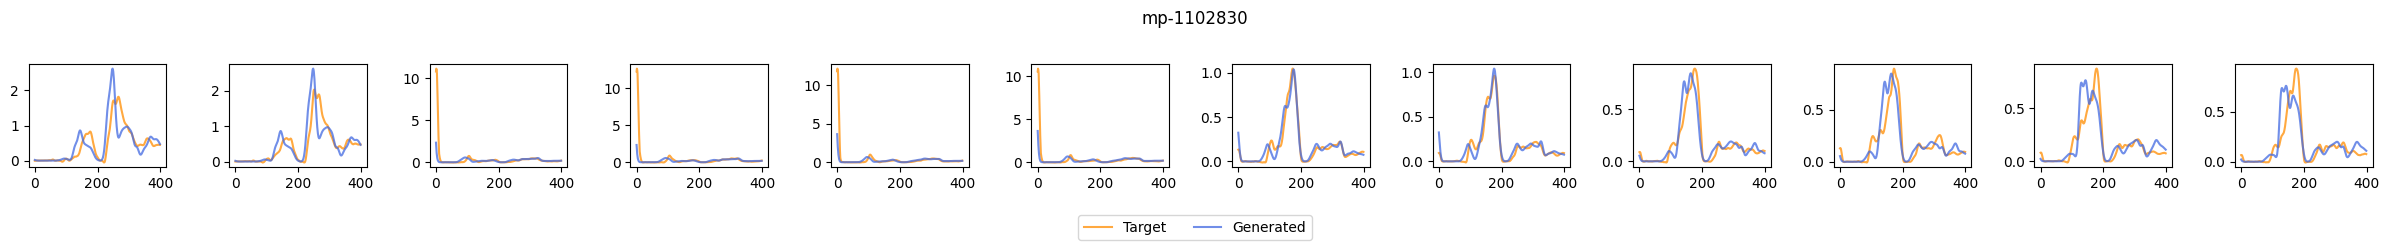

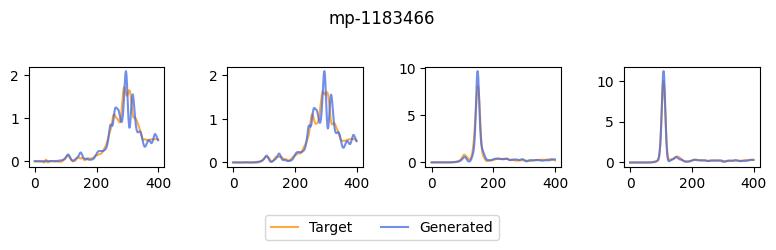

In [41]:
for key in batch.structure_id:
    plot_single(key, target_dos_dict[key], reconstructed_dos_dict[key])